# Imports and device

In [1]:
import sys
import os
sys.path.append(os.path.abspath("src"))
import torch
from src.trainer import Trainer
from src.models import NN_CartPole, NN_Humanoid, NN_Hopper
import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: mps


# Environment selection: only for the CartPole for now

In [2]:
str_env = "CartPole-v1"

# Configurations

In [3]:
updates = {"CartPole-v1": 80, "Humanoid-v5": 1000, "Hopper-v5": 500} # CartPole-v1: [60, 80, 100]
epochs = {"CartPole-v1": 20, "Humanoid-v5": 8, "Hopper-v5": 12} # CartPole-v1: [16, 20, 24] # Hopper-v5: [8, 12, 16] # Humanoid-v5: [6, 8, 10]
N = {"CartPole-v1": 20, "Humanoid-v5": 48, "Hopper-v5": 4} # CartPole-v1: [16, 20, 24] # Hopper-v5: [2, 4, 6] # Humanoid-v5: [40, 48, 56]
T = {"CartPole-v1": 128, "Humanoid-v5": 256, "Hopper-v5": 1024} # CartPole-v1: [64, 128, 256] # Hopper-v5: [512, 1024, 2048] # Humanoid-v5: [128, 256, 512]
batches = {"CartPole-v1": 4, "Humanoid-v5": 4, "Hopper-v5": 16} # CartPole-v1: [2, 4, 8] # Hopper-v5: [8, 16, 32] # Humanoid-v5: [2, 4, 8]
value_loss_coef = {"CartPole-v1": 0.5, "Humanoid-v5": 1.0, "Hopper-v5": 1.0} # CartPole-v1: [0.25, 0.5, 0.75] # Hopper-v5: [0.5, 1.0, 1.5] # Humanoid-v5: [0.5, 1.0, 1.5]
entropy_bonus_coef = {"CartPole-v1": 1e-3, "Humanoid-v5": 1e-5, "Hopper-v5": 5e-5} # CartPole-v1: [5e-4, 1e-3, 5e-3] # Hopper-v5: [1e-5, 5e-5, 1e-4] # Humanoid-v5: [5e-5, 1e-5, 5e-4]
clip_range = {"CartPole-v1": 0.1, "Humanoid-v5": 0.1, "Hopper-v5": 0.1} # CartPole-v1: [0.05, 0.1, 0.5] # Hopper-v5: [0.05, 0.1, 0.5] # Humanoid-v5: [0.05, 0.1, 0.5]
learning_rate = {"CartPole-v1": 5e-4, "Humanoid-v5": 3e-4, "Hopper-v5": 1e-4} # CartPole-v1: [1e-4, 5e-4, 1e-3] # Hopper-v5: [1e-5, 1e-4, 1e-3] # Humanoid-v5: [1e-4, 3e-4, 5e-4]
learning_rate_decay = {"CartPole-v1": 0.999, "Humanoid-v5": 0.99, "Hopper-v5": 0.999} # CartPole-v1: [0.99, 0.999, 0.9999] # Hopper-v5: [0.99, 0.999, 9999] # Humanoid-v5: [0.9, 0.99, 0.999]
reward_scaling = {"CartPole-v1": 0.5, "Humanoid-v5": 0.01, "Hopper-v5": 0.5} # CartPole-v1: [0.1, 0.5, 1.0] # Hopper-v5: [0.05, 0.1, 0.5] # Humanoid-v5: [0.001, 0.01, 0.1]
models = {"CartPole-v1": NN_CartPole, "Humanoid-v5": NN_Humanoid, "Hopper-v5": NN_Hopper}

# Configurations
configs = {
    # Number of updates
    'updates': updates[str_env],
    # Number of epochs to train the model with sampled data.
    'epochs': epochs[str_env],
    # Number of worker processes
    'N': N[str_env],
    # Number of steps to run on each process for a single update
    'T': T[str_env],
    # Number of mini batches
    'batches': batches[str_env],
    # Value loss coefficient.
    'value_loss_coef': value_loss_coef[str_env],
    # Entropy bonus coefficient.
    'entropy_bonus_coef': entropy_bonus_coef[str_env],
    # Clip range.
    'clip_range': clip_range[str_env],
    # Learning rate.
    'learning_rate': learning_rate[str_env],
    # Learning rate decay.
    'learning_rate_decay': learning_rate_decay[str_env],
    # Model to use
    'model': models[str_env](),
    # Device to use for training
    'device': device,
    # Environment to use
    'str_env': str_env,
    # Reward scaling
    'reward_scaling': reward_scaling[str_env]
}

# 25 runs to average the plots

In [4]:
episodes_length = np.zeros((25*N[str_env], updates[str_env]))
policy_loss_list = np.zeros((25, updates[str_env]*epochs[str_env]*batches[str_env]))
value_loss_list = np.zeros((25, updates[str_env]*epochs[str_env]*batches[str_env]))
entropy_bonus_list = np.zeros((25, updates[str_env]*epochs[str_env]*batches[str_env]))
clip_fraction_list = np.zeros((25, updates[str_env]*epochs[str_env]*batches[str_env]))

for i in range(25):
    configs = {
        # Number of updates
        'updates': updates[str_env],
        # Number of epochs to train the model with sampled data.
        'epochs': epochs[str_env],
        # Number of worker processes
        'N': N[str_env],
        # Number of steps to run on each process for a single update
        'T': T[str_env],
        # Number of mini batches
        'batches': batches[str_env],
        # Value loss coefficient.
        'value_loss_coef': value_loss_coef[str_env],
        # Entropy bonus coefficient.
        'entropy_bonus_coef': entropy_bonus_coef[str_env],
        # Clip range.
        'clip_range': clip_range[str_env],
        # Learning rate.
        'learning_rate': learning_rate[str_env],
        # Learning rate decay.
        'learning_rate_decay': learning_rate_decay[str_env],
        # Model to use
        'model': models[str_env](),
        # Device to use for training
        'device': device,
        # Environment to use
        'str_env': str_env,
        # Reward scaling
        'reward_scaling': reward_scaling[str_env]
    }
    trainer = Trainer(**configs)
    trainer.run_training_loop()
    episodes_length[i*N[str_env]:(i+1)*N[str_env], :] = np.array(trainer.episode_length)
    policy_loss_list[i, :] = -np.array(trainer.policy_loss_list)
    value_loss_list[i, :] = np.array(trainer.value_loss_list)
    entropy_bonus_list[i, :] = np.array(trainer.entropy_bonus_list)
    clip_fraction_list[i, :] = np.array(trainer.clip_fraction_list)
    trainer.destroy()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/juliengadonneix/rl_ic/lib/python3.11/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
/Users/juliengadonneix/rl_ic/lib/python3.11/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
/Users/juliengadonneix/rl_ic/lib/python3.11/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you re

# Plots

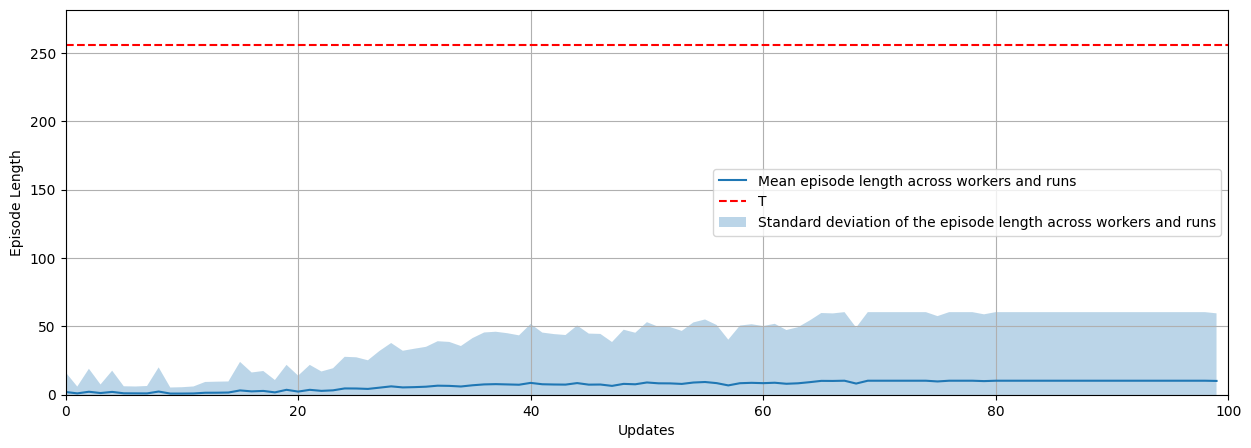

In [5]:
plt.figure(figsize=(15, 5))
mu = episodes_length.mean(axis=0)
plt.plot(mu, label="Mean episode length across workers and runs")
sigma = episodes_length.std(axis=0)
plt.axhline(y=T[str_env], color='r', linestyle='--', label="T")
plt.fill_between(np.arange(updates[str_env]), mu - sigma, np.minimum(T[str_env], mu + sigma), alpha=0.3, label="Standard deviation of the episode length across workers and runs")
plt.legend()
plt.xlabel("Updates")
plt.ylabel("Episode Length")
plt.xlim(0, updates[str_env])
plt.ylim(0, 1.1*T[str_env])
plt.grid()

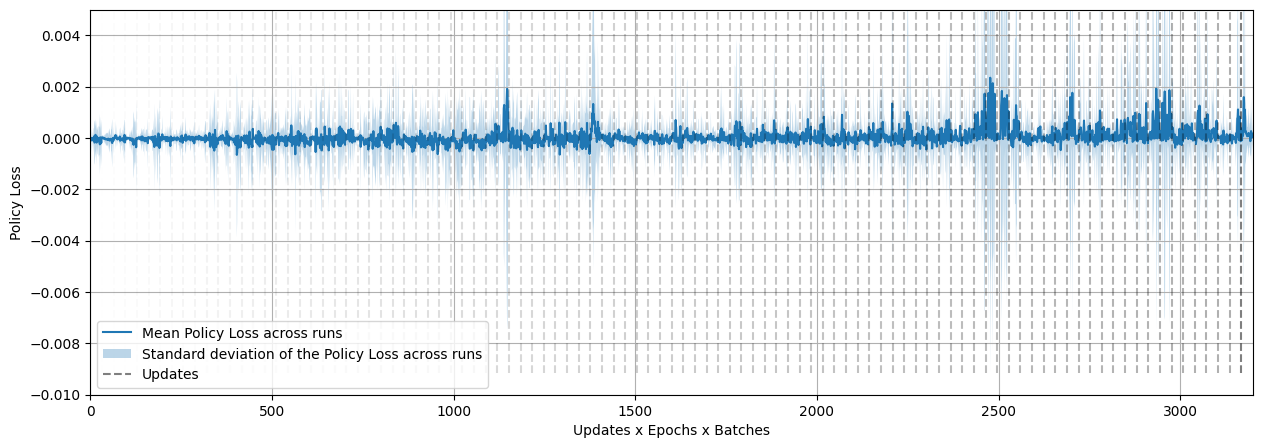

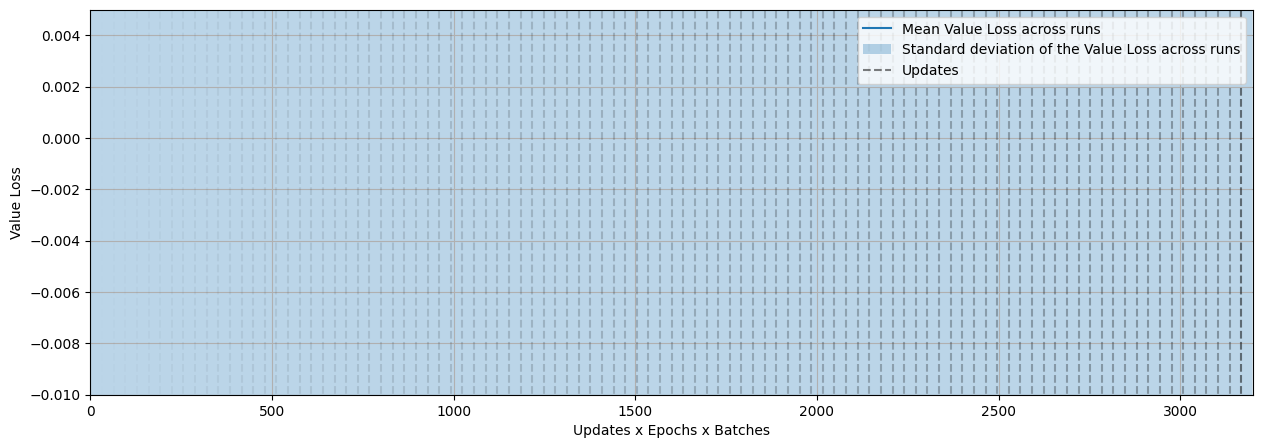

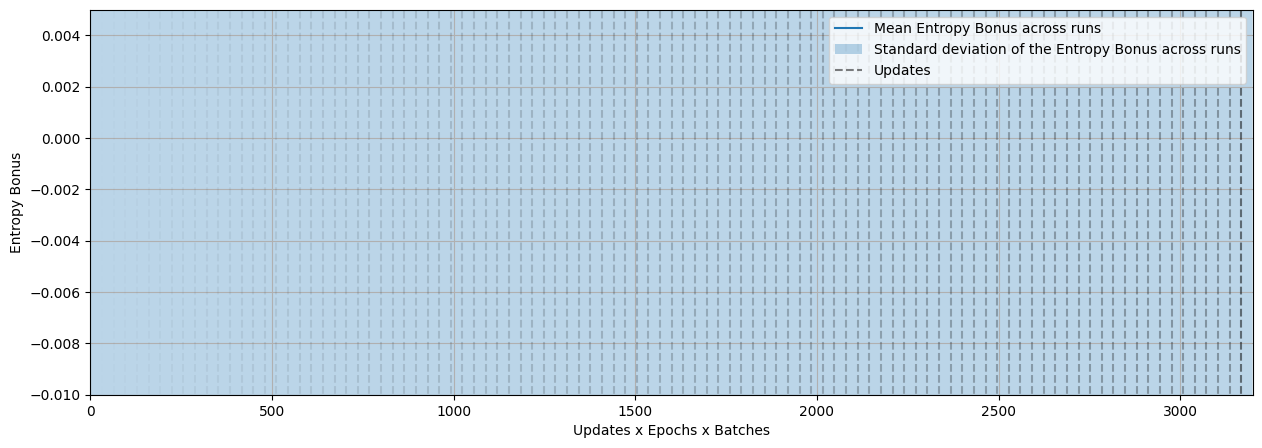

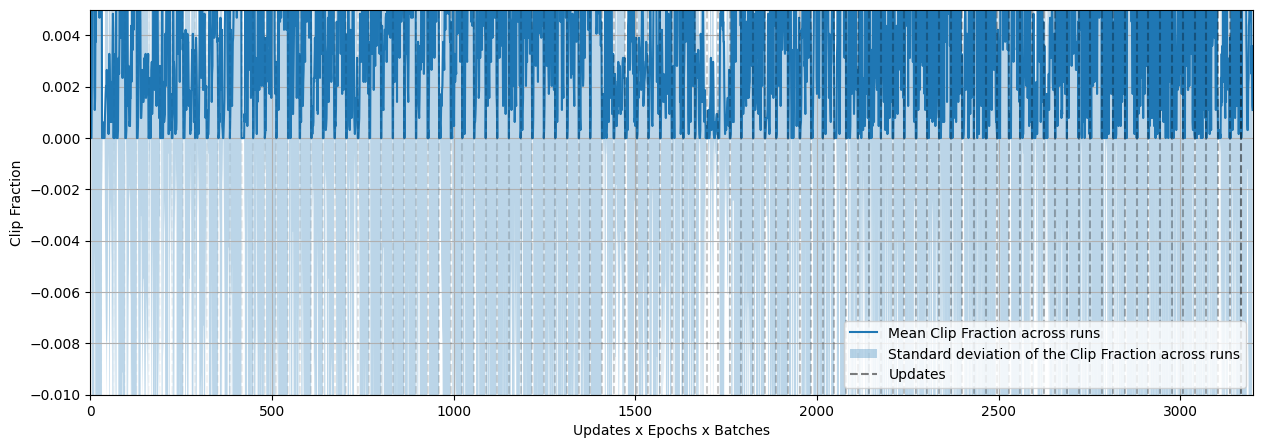

In [ ]:
names = ["Policy Loss", "Value Loss", "Entropy Bonus", "Clip Fraction"]
vals = [policy_loss_list, value_loss_list, entropy_bonus_list, clip_fraction_list]
for name, val in zip(names, vals):
    plt.figure(figsize=(15, 5))
    mu = val.mean(axis=0)
    plt.plot(mu, label="Mean " + name + " across runs")
    sigma = val.std(axis=0)
    plt.fill_between(np.arange(updates[str_env]*epochs[str_env]*batches[str_env]), mu-sigma, mu+sigma, alpha=0.3, label="Standard deviation of the " + name + " across runs")
    min_value = np.min(val)
    max_value = np.max(val)
    for i in range(updates[str_env]):
        if i == updates[str_env]-1:
            plt.vlines(i*epochs[str_env]*batches[str_env], min_value, max_value, color='k', linestyle='--', label="Updates", alpha=0.5)
        else:
            plt.vlines(i*epochs[str_env]*batches[str_env], min_value, max_value, color='k', linestyle='--', alpha=0.5*(1-np.exp(-i/100)))
    plt.xlabel("Updates x Epochs x Batches")
    plt.ylim(-0.01, 0.005)
    plt.xlim(0, updates[str_env]*epochs[str_env]*batches[str_env])
    plt.ylabel(name)
    plt.grid()
    plt.legend()